### 1. Loading preprocessed Clinical Data

In [6]:
import os
import glob
import numpy as np
import pandas as pd
import warnings
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
warnings.filterwarnings('ignore')
np.random.seed(123)

In [2]:
label_encoder = LabelEncoder()

In [11]:
training = pd.read_csv('train_data_resamples.csv')
testing = pd.read_csv('test_data_resamples.csv')

In [12]:
#drop case ID that contains LUNG-
training = training[~training['Case ID'].str.contains("LUNG-")]
testing = testing[~testing['Case ID'].str.contains("LUNG-")]

In [13]:
train_id = training['Case ID'].tolist()
test_id = testing['Case ID'].tolist()

scaler = StandardScaler()
training_scaled = scaler.fit_transform(training.drop(['Case ID','Histology'], axis = 1))
testing_scaled = scaler.transform(testing.drop(['Case ID','Histology'], axis = 1))

# replace the scaled columns
training_scaled_pd = pd.DataFrame(training_scaled)
training_scaled_pd.columns = training.drop(['Case ID','Histology'], axis = 1).columns

testing_scaled_pd = pd.DataFrame(testing_scaled)
testing_scaled_pd.columns = testing.drop(['Case ID','Histology'], axis = 1).columns

#replace column in training with the scaled columns
training_scaled_pd['Case ID'] = train_id
training_scaled_pd['Histology'] = training['Histology']

testing_scaled_pd['Case ID'] = test_id
testing_scaled_pd['Histology'] = testing['Histology']

training = training_scaled_pd
testing = testing_scaled_pd

In [14]:
PID = { 'R01-005','R01-012','R01-013','R01-014','R01-017','R01-021','R01-026','R01-027','R01-028','R01-029',
        'R01-038','R01-043','R01-046','R01-048','R01-049','R01-051','R01-052','R01-054','R01-055','R01-056',
        'R01-057','R01-059','R01-060','R01-061','R01-062','R01-063','R01-064','R01-065','R01-066','R01-067',
        'R01-068','R01-069','R01-071','R01-072','R01-073','R01-076','R01-078','R01-080','R01-081','R01-083',
        'R01-084','R01-089','R01-091','R01-093','R01-094','R01-096','R01-097','R01-098','R01-100','R01-101',
        'R01-102','R01-103','R01-104','R01-105','R01-106','R01-107','R01-108','R01-109','R01-110','R01-111',
        'R01-112','R01-113','R01-114','R01-115','R01-116','R01-117','R01-118','R01-119','R01-120','R01-121',
        'R01-122','R01-123','R01-124','R01-125','R01-126','R01-127','R01-128','R01-129','R01-130','R01-131',
        'R01-132','R01-133','R01-134','R01-135','R01-136','R01-138','R01-139','R01-140','R01-141','R01-142',
        'R01-144','R01-145','R01-146','R01-147','R01-148','R01-149','R01-151','R01-152','R01-154','R01-156',
        'R01-157','R01-158','R01-159','R01-160','LUNG-002','LUNG-004','LUNG-006','LUNG-009','LUNG-011',
        'LUNG-012','LUNG-018','LUNG-022','LUNG-030','LUNG-042','LUNG-045','LUNG-046','LUNG-047','LUNG-053',
        'LUNG-054','LUNG-061','LUNG-063','LUNG-068','LUNG-073','LUNG-078','LUNG-082','LUNG-086','LUNG-093',
        'LUNG-098','LUNG-099','LUNG-101','LUNG-104','LUNG-105','LUNG-116','LUNG-122','LUNG-135','LUNG-150',
        'LUNG-151','LUNG-173','LUNG-177','LUNG-193','LUNG-201','LUNG-202','LUNG-206','LUNG-208','LUNG-210'}

# Base directory
#CT Only
base_dir = './Lung Mask/'

# Store patient ID and corresponding image paths
image_paths_per_pid = {}

# Loop through each patient ID
for pid in PID:
    # Use glob to find all images starting with the patient ID
    image_paths = glob.glob(os.path.join(base_dir, f'{pid}*'))
    
    # Concatenate image paths with ";" and store in the dictionary
    image_paths_per_pid[pid] = ";".join(image_paths)

training['CT Images'] = training['Case ID'].map(image_paths_per_pid)
testing['CT Images'] = testing['Case ID'].map(image_paths_per_pid)

In [15]:
training['CT Images'] = training['CT Images'].str.split(';')
testing['CT Images'] = testing['CT Images'].str.split(';')
exploded_df_train = training.explode('CT Images')
exploded_df_test = testing.explode('CT Images')

In [16]:
PT_paths = []
for i in range(len(exploded_df_train)):
    p = exploded_df_train['Case ID'].iloc[i]
    frame = exploded_df_train['CT Images'].iloc[i].split('_')[2]
    #remove .jpg
    frame = frame[:-4]
    path = f'./Dataset Lung img/{p}/{p}_{frame}_PT_denoised.jpg'
    PT_paths.append(path)

exploded_df_train['PT Images'] = PT_paths

PT_paths = []
for i in range(len(exploded_df_test)):
    p = exploded_df_test['Case ID'].iloc[i]
    frame = exploded_df_test['CT Images'].iloc[i].split('_')[2]
    #remove .jpg
    frame = frame[:-4]
    path = f'./Dataset Lung img/{p}/{p}_{frame}_PT_denoised.jpg'
    PT_paths.append(path)

exploded_df_test['PT Images'] = PT_paths

In [18]:
train_data = exploded_df_train
test_data = exploded_df_test
train_data['Histology'] = exploded_df_train['Histology']
train_data['CT Images'] = exploded_df_train['CT Images']
train_data['PT Images'] = exploded_df_train['PT Images']
test_data['Histology'] = exploded_df_test['Histology']
test_data['CT Images'] = exploded_df_test['CT Images']
test_data['PT Images'] = exploded_df_test['PT Images']

train_data, valid_data = train_test_split(train_data, test_size=0.2, random_state=73)

In [19]:
train_data

,Age at Histological Diagnosis,Weight (lbs),Gender,Ethnicity,Smoking status,Pack Years,%GG,Tumor Location (choice=RUL),Tumor Location (choice=RML),Tumor Location (choice=RLL),...,LMO2,EGR2,BGN,COL4A1,COL5A1,COL5A2,Case ID,Histology,CT Images,PT Images
18,-1.850335,-0.899936,-1.600781,0.318874,0.00000,-1.615652,0.773389,-1.471960,0.433013,0.310087,...,-0.820678,-0.499391,-0.168007,-1.001331,-0.872148,0.122013,R01-014,0,./Lung Mask/R01-014_CT_73.jpg,./Dataset Lung img/R01-014/R01-014_73_PT_denoi...
34,-0.644348,1.341995,0.624695,0.318874,0.00000,1.208628,-0.604210,0.679366,-2.309401,0.310087,...,0.165363,0.196228,-0.839608,1.920355,-0.832067,-0.774695,R01-094,0,./Lung Mask/R01-094_CT_72.jpg,./Dataset Lung img/R01-094/R01-094_72_PT_denoi...
17,0.561640,-1.513517,-1.600781,0.318874,0.00000,-0.578891,1.691789,-1.471960,0.433013,0.310087,...,0.160929,-0.939248,-0.134072,0.880058,0.106198,0.022703,R01-100,0,./Lung Mask/R01-100_CT_82.jpg,./Dataset Lung img/R01-100/R01-100_82_PT_denoi...
42,-0.096171,-0.169185,0.624695,0.318874,-1.60963,0.136117,-0.604210,0.679366,-2.309401,0.310087,...,-0.418782,-0.333557,-0.793185,1.041334,-0.781890,-0.251079,R01-083,0,./Lung Mask/R01-083_CT_93.jpg,./Dataset Lung img/R01-083/R01-083_93_PT_denoi...
17,0.561640,-1.513517,-1.600781,0.318874,0.00000,-0.578891,1.691789,-1.471960,0.433013,0.310087,...,0.160929,-0.939248,-0.134072,0.880058,0.106198,0.022703,R01-100,0,./Lung Mask/R01-100_CT_80.jpg,./Dataset Lung img/R01-100/R01-100_80_PT_denoi...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14,1.219452,-0.380752,0.624695,0.318874,0.00000,-0.221387,-0.604210,-1.471960,0.433013,0.310087,...,-0.592385,-0.001935,0.091252,0.424699,0.341024,-0.138231,R01-103,0,./Lung Mask/R01-103_CT_88.jpg,./Dataset Lung img/R01-103/R01-103_88_PT_denoi...
14,1.219452,-0.380752,0.624695,0.318874,0.00000,-0.221387,-0.604210,-1.471960,0.433013,0.310087,...,-0.592385,-0.001935,0.091252,0.424699,0.341024,-0.138231,R01-103,0,./Lung Mask/R01-103_CT_85.jpg,./Dataset Lung img/R01-103/R01-103_85_PT_denoi...
17,0.561640,-1.513517,-1.600781,0.318874,0.00000,-0.578891,1.691789,-1.471960,0.433013,0.310087,...,0.160929,-0.939248,-0.134072,0.880058,0.106198,0.022703,R01-100,0,./Lung Mask/R01-100_CT_72.jpg,./Dataset Lung img/R01-100/R01-100_72_PT_denoi...
5,-0.644348,0.351179,0.624695,0.318874,0.00000,-0.221387,-0.604210,0.679366,0.433013,0.310087,...,0.585977,-0.375758,-0.249053,0.189485,-0.249335,0.099465,R01-068,0,./Lung Mask/R01-068_CT_91.jpg,./Dataset Lung img/R01-068/R01-068_91_PT_denoi...


### 2. MedClip Model

In [21]:
import torch
import torch.nn as nn
from transformers import CLIPProcessor, CLIPModel
from PIL import Image
import pandas as pd
from sklearn.metrics import accuracy_score
import numpy as np

# Load the MedCLIP model and processor
# Note: Replace the model and processor names with actual MedCLIP model names when available.
model = CLIPModel.from_pretrained("flaviagiammarino/pubmed-clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("flaviagiammarino/pubmed-clip-vit-base-patch32")


train_data["Histopathological Grade"] = label_encoder.fit_transform(train_data["Histopathological Grade"])

# Example: Extracting a row of features and label
example_row = train_data.iloc[0]  # Extract the first row of the dataframe
#features = torch.tensor([example_row[['Age at Histological Diagnosis', 'Smoking status', 'Pathological T stage', 'Pathological N stage', 'Pathological M stage', 'EGFR mutation status', 'Histopathological Grade', 'Recurrence','KRAS mutation status']].values])  # Replace with your actual feature column names
label = example_row['Histology']

# Extract features and ensure they are in a suitable numeric format
features_np = example_row.drop(['Case ID', 'Histology', 'CT Images', 'PT Images']).values


# Ensure data is in a suitable format (e.g., float)
features_np = features_np.astype(np.float32)

# Convert to PyTorch tensor
features = torch.tensor([features_np])

# Example text and image
text = ["A patient with a history of lung cancer"]
image_path = "./Fused Lung 2 copy/R01-149_74_Fused.jpg"  # Replace with the path to your CT image
image = Image.open(image_path)
image_path_2 = "./Dataset Lung img/R01-149/R01-149_74_PT_denoised.jpg"  # Replace with the path to your CT image
image_2 = Image.open(image_path_2)
# Preprocess the text and image
inputs = processor(
    text=text, 
    images=image, 
    return_tensors="pt", 
    padding=True
)

inputs_2 = processor(
    text=text, 
    images=image_2, 
    return_tensors="pt", 
    padding=True
)


# Forward pass
outputs = model(**inputs)

outputs_2 = model(**inputs_2)
# Extract image and text features
image_features = outputs.image_embeds
image_features_2 = outputs_2.image_embeds
# Concatenate image features and tabular data
combined_features = torch.cat((image_features, image_features_2, features), dim=1)


import torch
import torch.nn as nn
import torch.nn.functional as F

class Classifier(nn.Module):
    def __init__(self, input_dim):
        super(Classifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 256)  # First hidden layer
        self.fc2 = nn.Linear(256, 128)        # Second hidden layer
        self.fc3 = nn.Linear(128, 64)         # Third hidden layer
        self.fc4 = nn.Linear(64, 32)          # Fourth hidden layer
        self.fc5 = nn.Linear(32, 1)           # Output layer
        
        # Dropout for regularization (can adjust rate as needed)
        self.dropout = nn.Dropout(p=0.5)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))  # Activation for first hidden layer
        x = self.dropout(x)      # Dropout for first hidden layer
        x = F.relu(self.fc2(x))  # Activation for second hidden layer
        x = self.dropout(x)      # Dropout for second hidden layer
        x = F.relu(self.fc3(x))  # Activation for third hidden layer
        x = self.dropout(x)      # Dropout for third hidden layer
        x = F.relu(self.fc4(x))  # Activation for fourth hidden layer
        x = self.dropout(x)      # Dropout for fourth hidden layer
        x = torch.sigmoid(self.fc5(x))  # Sigmoid activation for output layer
        return x


# Initialize the classifier
input_dim = combined_features.size(1)
classifier = Classifier(input_dim)

# Forward pass through the classifier
predictions = classifier(combined_features)

# Applying a threshold to get class labels
threshold = 0.5
predicted_labels = (predictions >= threshold).int()

# Convert labels to numpy array or list for further usage
predicted_labels_np = predicted_labels.detach().cpu().numpy()

# Compute accuracy by comparing predictions to actual labels
accuracy = accuracy_score([label], predicted_labels_np)
print("Accuracy:", accuracy)



Accuracy: 1.0


In [24]:
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
from torchvision.io import read_image


transform = transforms.Compose([
    transforms.RandomRotation(degrees=10),  # Random rotation between -10 and 10 degrees
    transforms.RandomHorizontalFlip(p=0.5),  # Horizontal flipping with probability 0.5
    transforms.RandomVerticalFlip(p=0.5),  # Vertical flipping with probability 0.5
    transforms.RandomResizedCrop(size=(224, 224), scale=(0.8, 1.0)),  # Random cropping and resizing
    transforms.ToTensor(),  # Convert PIL image to PyTorch tensor
    #transforms.Normalize(mean=[mean], std=[std]),
])

class NSLCDataset(Dataset):
    def __init__(self, dataframe, processor, transform=None):
        self.dataframe = dataframe
        self.processor = processor
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        cancer_type = 'Adenocarcinoma' if row['Histology'] == 0 else 'Squamous cell carcinoma'
        text = ["A photo of " + cancer_type + " cancer"]
        image_paths = row['CT Images'].split(';')
        pt = row['PT Images'].split(';')
        image_paths.extend(pt)
        images = [Image.open(img_path) for img_path in image_paths]
        
        # Apply transformations if any
        if self.transform:
            images = [self.transform(image) for image in images]
        
        # Process each image and text separately and stack image tensors
        inputs_list = [self.processor(text=text, images=image, return_tensors="pt", padding='max_length', max_length=32) for image in images]

        image_tensors = torch.stack([inp['pixel_values'].squeeze(0) for inp in inputs_list], dim=0)
        # Average or sum the image features if you're using multiple images
        inputs = {
            'input_ids': inputs_list[0]['input_ids'],  # Using the text input from the first item
            'pixel_values': image_tensors.mean(dim=0).unsqueeze(0)  # Averaging the image inputs and adding batch dimension
        }
        

        features_np = row.drop(['Case ID', 'Histology', 'CT Images', 'PT Images']).values.astype(np.float32)
        
        features = torch.tensor([features_np])
        label = torch.tensor(row['Histology']).float()
        return inputs, features, label

#train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)
#valid_data, test_data = train_test_split(test_data, test_size=0.5, random_state=42)

# Creating Datasets
train_dataset = NSLCDataset(train_data, processor)

valid_dataset = NSLCDataset(valid_data, processor)
test_dataset = NSLCDataset(test_data, processor)

# Creating DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Training Loop
num_epochs = 5

criterion = nn.BCELoss()
optimizer = torch.optim.Adam(classifier.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5)

classifier = Classifier(564)

for epoch in range(num_epochs):
    classifier.train()
    running_loss = 0.0
    all_labels = []
    all_preds = []
    for inputs, features, labels in train_loader:
        optimizer.zero_grad()
        inputs['pixel_values'] = inputs['pixel_values'].squeeze(1)
        inputs['input_ids'] = inputs['input_ids'].squeeze(1)
        outputs = model(**inputs)
        image_features = outputs.image_embeds
        features = features.squeeze(1)
        combined_features = torch.cat((image_features, features), dim=1)
        predictions = classifier(combined_features)
        if (predictions.squeeze().shape != labels.shape):
            continue
        # print(predictions.squeeze().shape)
        # print(labels.shape)
        loss = criterion(predictions.squeeze(), labels)
        loss.backward()
        optimizer.step()
        all_labels.append(labels.cpu().numpy())
        all_preds.append(torch.round(predictions).cpu().detach().numpy())

        running_loss += loss.item()

    all_labels = np.concatenate(all_labels)
    all_preds = np.concatenate(all_preds)
    accuracy = accuracy_score(all_labels, all_preds)
    
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader)}, Accuracy: {accuracy*100:.2f}%")

# Validation Loop
# classifier.eval()
# all_preds = []
# all_labels = []
# with torch.no_grad():
#     for inputs, features, labels in valid_loader:
#         inputs['pixel_values'] = inputs['pixel_values'].squeeze(1)
#         inputs['input_ids'] = inputs['input_ids'].squeeze(1)
#         outputs = model(**inputs)
#         image_features = outputs.image_embeds
#         features = features.squeeze(1)
#         combined_features = torch.cat((image_features, features), dim=1)
#         predictions = classifier(combined_features)
#         all_preds.append(predictions.squeeze().cpu().numpy())
#         all_labels.append(labels.cpu().numpy())
# all_preds = np.concatenate(all_preds)
# all_labels = np.concatenate(all_labels)
# accuracy = accuracy_score(all_labels, all_preds >= 0.5)
# print(f"Validation Accuracy: {accuracy*100:.2f}%")


classifier.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for inputs, features, labels in test_loader:
        inputs['pixel_values'] = inputs['pixel_values'].squeeze(1)
        inputs['input_ids'] = inputs['input_ids'].squeeze(1)
        outputs = model(**inputs)
        image_features = outputs.image_embeds
        features = features.squeeze(1)
        combined_features = torch.cat((image_features, features), dim=1)
        predictions = classifier(combined_features)
        all_preds.append(predictions.squeeze().cpu().numpy())
        all_labels.append(labels.cpu().numpy())
all_preds = np.concatenate(all_preds)
all_labels = np.concatenate(all_labels)
accuracy = accuracy_score(all_labels, all_preds >= 0.5)
print(f"Testing Accuracy: {accuracy*100:.2f}%")

In [18]:
classifier.eval()
all_preds = []
all_labels = []
count = 0
with torch.no_grad():
    for inputs, features, labels in test_loader:
        inputs['pixel_values'] = inputs['pixel_values'].squeeze(1)
        inputs['input_ids'] = inputs['input_ids'].squeeze(1)
        outputs = model(**inputs)
        image_features = outputs.image_embeds
        features = features.squeeze(1)
        combined_features = torch.cat((image_features, features), dim=1)
        predictions = classifier(combined_features)
        predictions_numpy = predictions.squeeze().cpu().numpy()
        labels_numpy = labels.cpu().numpy()
        all_preds.append(predictions.squeeze().cpu().numpy())
        all_labels.append(labels.cpu().numpy())
        count += 1
all_preds = np.concatenate(all_preds)
all_labels = np.concatenate(all_labels)
accuracy = accuracy_score(all_labels, all_preds >= 0.5)
print(f"Testing Accuracy: {accuracy*100:.2f}%")

Testing Accuracy: 75.89%


              precision    recall  f1-score   support

     Class 0       0.80      0.76      0.78       612
     Class 1       0.72      0.75      0.73       487

    accuracy                           0.76      1099
   macro avg       0.76      0.76      0.76      1099
weighted avg       0.76      0.76      0.76      1099



<Axes: >

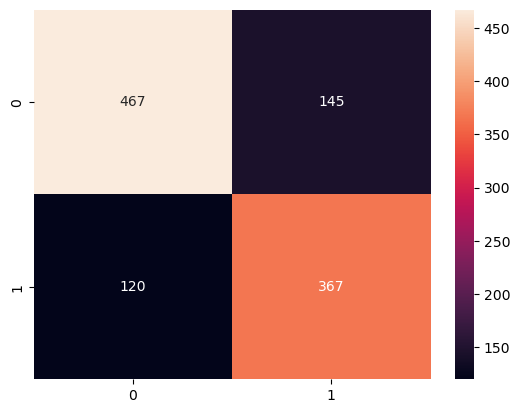

In [19]:
from sklearn.metrics import classification_report
binary_predictions = (all_preds >= 0.5).astype(int)


print(classification_report(all_labels, binary_predictions, target_names=['Class 0', 'Class 1']))

#Confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
cm = confusion_matrix(all_labels, binary_predictions)
sns.heatmap(cm, annot=True, fmt='d')

In [20]:
torch.save(model, './models/MedClip_CT_2D.pth')
torch.save(model.state_dict(), './models/MedClip_CT_2D_weights.pth')